# HSCT survival: gradient boosting decision tree ensemble model

## Notebook set-up

In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from scipy import stats
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV
from sklearn.metrics import root_mean_squared_error
from lifelines.utils import concordance_index

import configuration as config
import functions.helper as helper_funcs

# Data files
raw_training_data_file=f'{config.DATA_PATH}/raw/train.csv'
raw_testing_data_file=f'{config.DATA_PATH}/raw/train.csv'

# Model files
naive_model_file=f'{config.MODELS_PATH}/05.2-XGBoost_naive.pkl'
tuned_model_file=f'{config.MODELS_PATH}/05.2-SGBoost_tuned.pkl'

retune_model=True

## 1. Load data

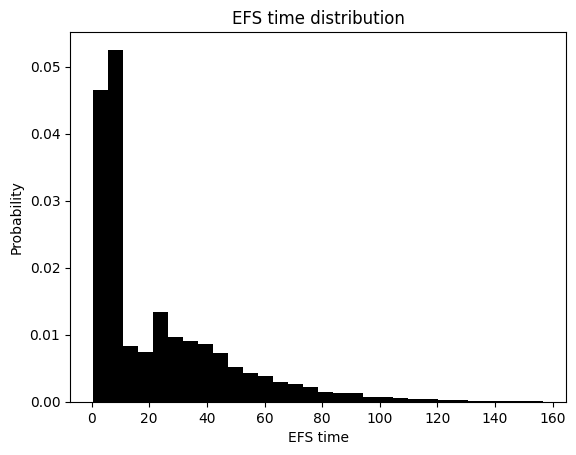

Training features: (28800, 59)


In [2]:
df=pd.read_csv(raw_training_data_file, index_col='ID')

plt.title('EFS time distribution')
plt.hist(df['efs_time'], density=True, bins=30, color='black')
plt.xlabel('EFS time')
plt.ylabel('Probability')
plt.show()

print(f'Training features: {df.shape}')

In [3]:
# Save race group
race_group=df['race_group']

# Encode
df=pd.get_dummies(df, drop_first=True)

# Clean up column names
df.columns=df.columns.str.replace('[\\[\\]<]', '', regex=True)

# Add back race_group
df['race_group']=race_group

## 2. Train-test split

In [4]:
training, testing=train_test_split(df, test_size=0.33, random_state=315)

training_df=pd.DataFrame(training, columns=df.columns)
testing_df=pd.DataFrame(testing, columns=df.columns)

training_race_group=training_df['race_group']
testing_race_group=testing_df['race_group']

training_df.drop('race_group', axis=1, inplace=True)
testing_df.drop('race_group', axis=1, inplace=True)

training_labels_df=training_df[['efs', 'efs_time']]
training_features_df=training_df.drop(['efs', 'efs_time'], axis=1)

testing_labels_df=testing_df[['efs', 'efs_time']]
testing_features_df=testing_df.drop(['efs', 'efs_time'], axis=1)

## 3. Naive model

In [5]:
# XGBoost Model
xgb_params={
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'learning_rate': 0.05,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'seed': 42
}

## 4. Cross-validate naive model

In [ ]:
# Cross-validation splitter
k_fold=KFold(n_splits=30, shuffle=True, random_state=42)

# Collector for scores
scores=[]

# Loop on cross-validation folds
for i, (training_idx, validation_idx) in enumerate(k_fold.split(training_df)):

    # Get the features for this fold
    training_features=training_df.iloc[training_idx].drop(['efs', 'efs_time'], axis=1)
    validation_features=training_df.iloc[validation_idx].drop(['efs', 'efs_time'], axis=1)

    # Get the labels
    training_labels=training_df.iloc[training_idx]['efs_time']
    validation_labels=training_df.iloc[validation_idx]['efs_time']

    # Convert to DMaxtrix for XGBoost training
    dtraining=xgb.DMatrix(training_features, label=training_labels)
    dvalidation=xgb.DMatrix(validation_features, label=validation_labels)

    naive_model=xgb.train(
        xgb_params,
        dtraining,
        num_boost_round=1000,
        evals=[(dtraining, 'training'), (dvalidation, 'validation')],
        early_stopping_rounds=100,
        verbose_eval=0
    )

    predictions=naive_model.predict(dvalidation)
    scores.append(root_mean_squared_error(validation_labels, predictions))

cross_val_scores={'Naive model': scores}
print(f'\nCross-validation RMSE: {np.array(scores).mean():.3f} +/- {np.array(scores).std():.3f}')

## 5. Fit and evaluate naive model on test set

In [ ]:
# Convert testing features & labels and convert to DMaxtrix for XGBoost training
testing_features=testing_df.drop(['efs', 'efs_time'], axis=1)
testing_labels=testing_df['efs_time']
dtesting=xgb.DMatrix(testing_features, label=testing_labels)

naive_model=xgb.train(
    xgb_params,
    dtraining,
    num_boost_round=1000,
    evals=[(dtraining, 'training')],
    early_stopping_rounds=100,
    verbose_eval=100
)

# Make predictions for the whole test set
predicted_efs_time=naive_model.predict(dtesting)

# Get and save the RMSE for later
rmse=root_mean_squared_error(testing_labels_df['efs_time'], predicted_efs_time)
rmse_results={'Naive model': rmse}

# Get and save the concordance index for later
cindex=concordance_index(
    testing_labels_df['efs_time'],
    predicted_efs_time,
    testing_labels_df['efs']
)

cindex_results={'Naive model': cindex}

# Get and save stratified concordance index for later
results_df=pd.DataFrame({'ID': testing_df.index, 'prediction': predicted_efs_time})
results_df['race_group']=testing_race_group
results_df['efs_time']=testing_labels_df['efs_time']
results_df['efs']=testing_labels_df['efs']
solution=results_df.drop(['ID', 'prediction'], axis=1)
submission=results_df.drop(['race_group','efs_time','efs'], axis=1)
score=helper_funcs.competition_score(solution, submission)
stratified_cindex_results={'Naive model': score}

# Plot the results
fig, axs=plt.subplots(1,3, figsize=(10,4))
axs=axs.flatten()

fig.suptitle('Naive gradient regression model test set performance')

axs[0].set_title('Actual vs predicted EFS time')
axs[0].scatter(testing_labels_df['efs_time'], predicted_efs_time, color='black', s=0.2)
axs[0].set_xlabel('True EFS time')
axs[0].set_ylabel('Predicted EFS time')

axs[1].set_title('EFS residual as a function of fitted value')
axs[1].scatter(predicted_efs_time, testing_labels_df['efs_time'] - predicted_efs_time, color='black', s=0.2)
axs[1].set_xlabel('EFS time')
axs[1].set_ylabel('true - predicted EFS time')

axs[2].set_title('Normal quantile plot')
stats.probplot(testing_labels_df['efs_time'] - predicted_efs_time, plot=axs[2])
axs[2].get_lines()[0].set_markeredgecolor('black')
axs[2].get_lines()[0].set_markerfacecolor('black')
axs[2].set_xlabel('Normal quantiles')
axs[2].set_ylabel('Residuals')

plt.tight_layout()
plt.show()

In [ ]:
# Save the model
with open(naive_model_file, 'wb') as output_file:
    pickle.dump(naive_model, output_file)

## 6. Hyperparameter tuning

Current search space runs at about a minute per iteration.

In [ ]:
%%time

# Train or load model as desired
if retune_model == True:
    
    # Instantiate the model
    model=xgb.XGBRegressor(
        objective='reg:squarederror',
        eval_metric='rmse',
        random_state=315
    )

    # Define the cross-validation strategy
    cross_validation=KFold(n_splits=7, shuffle=True, random_state=315)

    # Define the hyperparameter search space
    distributions={
        'learning_rate': stats.uniform(loc=0.0001, scale=0.0999),
        'n_estimators': list(range(5, 100)),
        'max_depth': list(range(5, 50)),
        'num_parallel_tree': list(range(1, 5)),
        'gamma': stats.uniform(loc=0.0001, scale=0.9999),
        'subsample': stats.uniform(loc=0.5, scale=0.4)
    }

    # Set-up the search
    search=RandomizedSearchCV(
        model,
        distributions,
        scoring='neg_root_mean_squared_error',
        n_jobs=1,
        cv=cross_validation,
        n_iter=500,
        random_state=315,
        return_train_score=True
    )

    results=search.fit(
        training_features_df,
        training_labels_df['efs_time'],
    )
    
    print(f'Best hyperparameters: {results.best_params_}')

    # Instantiate the model with the tuned hyperparameters
    tuned_model=xgb.XGBRegressor(
        **results.best_params_,
        objective='reg:squarederror',
        eval_metric='rmse',
        random_state=315
    )
    
    tuned_model.fit(
        training_features_df,
        training_labels_df['efs_time'],
    )

    with open(tuned_model_file, 'wb') as output_file:
        pickle.dump(tuned_model, output_file)
    
elif retune_model == False:
    with open(tuned_model_file, 'rb') as input_file:
        tuned_model=pickle.load(input_file)

print()

## 7. Cross-validate tuned model

In [ ]:
# Run cross-validation to estimate out-of-sample performance
scores=helper_funcs.cross_val(
    tuned_model,
    training_features_df,
    training_labels_df['efs_time'],
    folds=30
)

cross_val_scores['Tuned model']=scores

## 8. Fit and evaluate tuned model on test set

In [ ]:
# Make predictions on the training set
predicted_efs_time=tuned_model.predict(testing_features_df)

# Save the RMSE for later
rmse_results['Tuned model']=root_mean_squared_error(testing_labels_df['efs_time'], predicted_efs_time)

# Save the concordance index for later
cindex_results['Tuned model']=concordance_index(
    testing_labels_df['efs_time'],
    predicted_efs_time,
    testing_labels_df['efs']
)

# Get and save stratified concordance index for later
results_df=pd.DataFrame({'ID': testing_df.index, 'prediction': predicted_efs_time})
results_df['race_group']=testing_race_group
results_df['efs_time']=testing_labels_df['efs_time']
results_df['efs']=testing_labels_df['efs']
solution=results_df.drop(['ID', 'prediction'], axis=1)
submission=results_df.drop(['race_group','efs_time','efs'], axis=1)
stratified_cindex_results['Tuned model']=helper_funcs.competition_score(solution, submission)

# Plot the results
fig, axs=plt.subplots(1,3, figsize=(10,4))
axs=axs.flatten()

fig.suptitle('Tuned gradient boosting regression model performance')

axs[0].set_title('Actual vs predicted EFS time')
axs[0].scatter(testing_labels_df['efs_time'], predicted_efs_time, color='black', s=0.2)
axs[0].set_xlabel('True EFS time')
axs[0].set_ylabel('Predicted EFS time')

axs[1].set_title('EFS residual as a function of fitted value')
axs[1].scatter(predicted_efs_time, testing_labels_df['efs_time'] - predicted_efs_time, color='black', s=0.2)
axs[1].set_xlabel('EFS time')
axs[1].set_ylabel('true - predicted EFS time')

axs[2].set_title('Normal quantile plot')
stats.probplot(testing_labels_df['efs_time'] - predicted_efs_time, plot=axs[2])
axs[2].get_lines()[0].set_markeredgecolor('black')
axs[2].get_lines()[0].set_markerfacecolor('black')
axs[2].set_xlabel('Normal quantiles')
axs[2].set_ylabel('Residuals')

plt.tight_layout()
plt.show()

## 9. Model comparison

### 9.1. Cross-validation performance

In [ ]:
import numpy as np

# Collect scores
joined_scores=[]

for scores in cross_val_scores.values():
    joined_scores.extend(scores)

_, bins=np.histogram(joined_scores)

plt.title('Cross-validation performance comparison')

for model, scores in cross_val_scores.items():
    plt.hist(scores, bins=bins, alpha=0.7, label=model)
    
plt.xlabel('Validation RMSE')
plt.ylabel('Samples')
plt.legend(loc='best')
plt.show()

### 9.2. Test set performance

#### 9.2.1 RMSE

In [ ]:
for model, score in rmse_results.items():
    print(f'{model} RMSE: {score}')

#### 9.2.2. Concordance index

In [ ]:
for model, score in cindex_results.items():
    print(f'{model} concordance index: {score}')

#### 9.2.3. Stratified concordance index

In [ ]:
for model, score in stratified_cindex_results.items():
    print(f'{model} stratified concordance index: {score}')